In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [2]:
from google.colab import files
uploaded = files.upload()


Saving spambase_csv_Kaggle.csv to spambase_csv_Kaggle.csv


In [3]:
df = pd.read_csv("spambase_csv_Kaggle.csv")
print(df.head())
print(df.shape)
print(df.isnull().sum())

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_%3B  char_freq_%28  \
0             0.00            0.00  ...           0.00          0.0

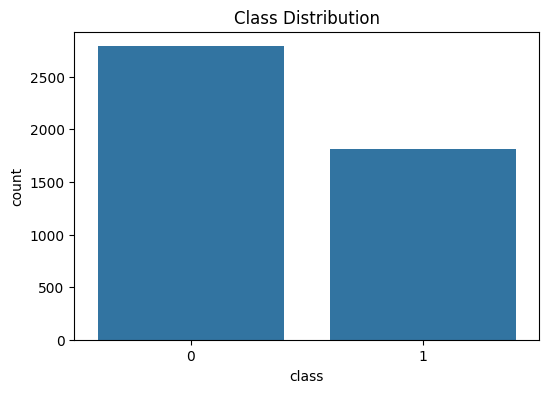

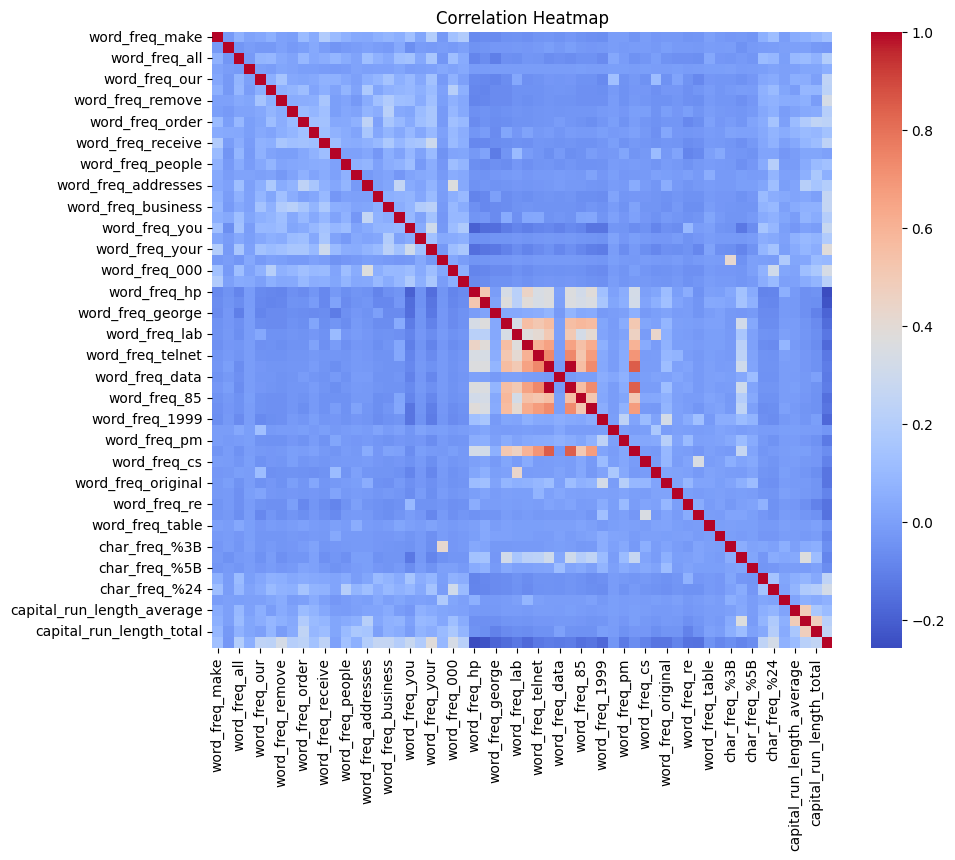

In [4]:
# 2. EDA
# -----------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=df)
plt.title("Class Distribution")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [5]:
X = df.drop("class", axis=1)
y = df["class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [6]:
start = time.time()
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_time = time.time() - start

y_pred_log = log_model.predict(X_test)

log_acc = accuracy_score(y_test, y_pred_log)
log_prec = precision_score(y_test, y_pred_log)
log_rec = recall_score(y_test, y_pred_log)
log_f1 = f1_score(y_test, y_pred_log)

print("\nBaseline Logistic Regression")
print("Accuracy:", log_acc)
print("Precision:", log_prec)
print("Recall:", log_rec)
print("F1:", log_f1)
print("Training Time:", log_time)


Baseline Logistic Regression
Accuracy: 0.9196525515743756
Precision: 0.9316939890710383
Recall: 0.8743589743589744
F1: 0.9021164021164021
Training Time: 0.04913663864135742


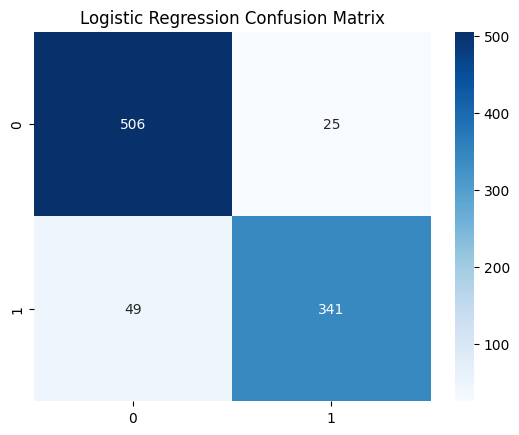

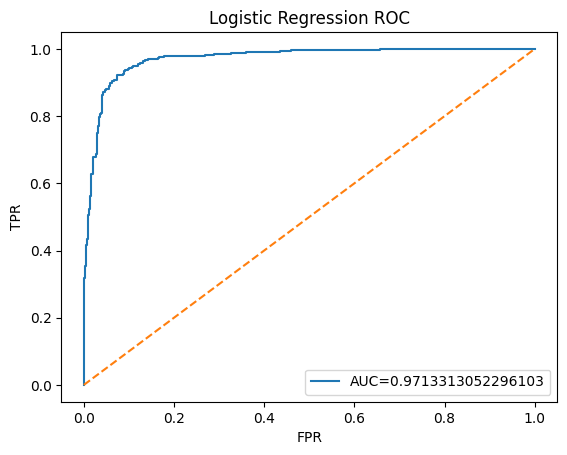

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# ROC Curve
y_prob = log_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression ROC")
plt.legend()
plt.show()

In [9]:
# -----------------------------
# 5. HYPERPARAMETER TUNING - LOGISTIC
# -----------------------------
log_params = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"]
}

grid_log = GridSearchCV(
    LogisticRegression(max_iter=5000),
    log_params,
    cv=5,
    scoring="accuracy"
)

grid_log.fit(X_train, y_train)

print("\nBest Logistic Parameters:", grid_log.best_params_)
print("Best CV Accuracy:", grid_log.best_score_)

best_log = grid_log.best_estimator_
y_pred_best_log = best_log.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Best Logistic Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Accuracy: 0.9274456521739131


In [10]:
# -----------------------------
# 6. SVM KERNEL COMPARISON
# -----------------------------
kernels = ["linear", "poly", "rbf", "sigmoid"]
svm_results = {}

for k in kernels:
    start = time.time()
    svm = SVC(kernel=k)
    svm.fit(X_train, y_train)
    t = time.time() - start

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    svm_results[k] = (acc, f1, t)

print("\nSVM Kernel Performance")
for k,v in svm_results.items():
    print(k, "Accuracy:", v[0], "F1:", v[1], "Time:", v[2])



SVM Kernel Performance
linear Accuracy: 0.9250814332247557 F1: 0.9090909090909091 Time: 0.6817996501922607
poly Accuracy: 0.7643865363735071 F1: 0.629059829059829 Time: 0.57244873046875
rbf Accuracy: 0.9348534201954397 F1: 0.9206349206349206 Time: 0.34151577949523926
sigmoid Accuracy: 0.8892508143322475 F1: 0.8664921465968587 Time: 0.35155177116394043


In [11]:
# -----------------------------
# 7. HYPERPARAMETER TUNING - SVM
# -----------------------------
svm_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto"],
    "degree": [2,3,4]
}

grid_svm = GridSearchCV(
    SVC(),
    svm_params,
    cv=5,
    scoring="accuracy"
)

grid_svm.fit(X_train, y_train)

print("\nBest SVM Parameters:", grid_svm.best_params_)
print("Best CV Accuracy:", grid_svm.best_score_)

best_svm = grid_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)


Best SVM Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.93125


In [12]:
# -----------------------------
# 8. FINAL METRICS
# -----------------------------
def print_metrics(name, y_true, y_pred):
    print("\n",name)
    print("Accuracy:", accuracy_score(y_true,y_pred))
    print("Precision:", precision_score(y_true,y_pred))
    print("Recall:", recall_score(y_true,y_pred))
    print("F1:", f1_score(y_true,y_pred))

print_metrics("Tuned Logistic Regression", y_test, y_pred_best_log)
print_metrics("Tuned SVM", y_test, y_pred_best_svm)



 Tuned Logistic Regression
Accuracy: 0.9174809989142236
Precision: 0.9197860962566845
Recall: 0.882051282051282
F1: 0.900523560209424

 Tuned SVM
Accuracy: 0.9348534201954397
Precision: 0.9508196721311475
Recall: 0.8923076923076924
F1: 0.9206349206349206


In [13]:
# -----------------------------
# 9. 5-FOLD CROSS VALIDATION
# -----------------------------
log_cv = cross_val_score(best_log, X_scaled, y, cv=5)
svm_cv = cross_val_score(best_svm, X_scaled, y, cv=5)

print("\n5-Fold CV Logistic:", log_cv)
print("Average:", log_cv.mean())

print("\n5-Fold CV SVM:", svm_cv)
print("Average:", svm_cv.mean())


5-Fold CV Logistic: [0.91965255 0.92934783 0.89565217 0.95       0.825     ]
Average: 0.9039305103148753

5-Fold CV SVM: [0.93268187 0.93369565 0.95       0.94891304 0.85      ]
Average: 0.9230581126374922


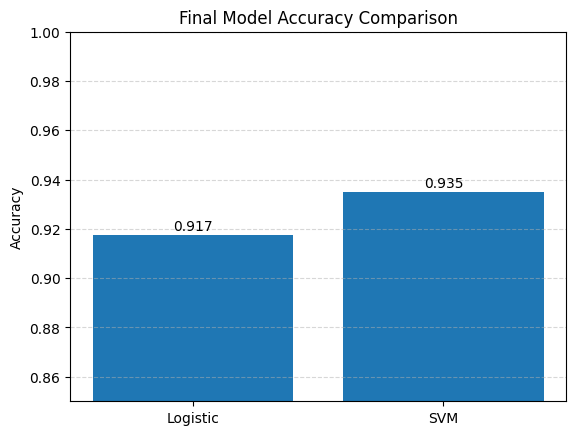

In [15]:
# -----------------------------
# 10. BAR CHART COMPARISON
# -----------------------------
models = ["Logistic", "SVM"]
accs = [accuracy_score(y_test,y_pred_best_log),
        accuracy_score(y_test,y_pred_best_svm)]

plt.bar(models, accs)
plt.title("Final Model Accuracy Comparison")
plt.ylabel("Accuracy")

plt.ylim(0.85, 1.0)   # zoom range
plt.grid(axis='y', linestyle='--', alpha=0.5)

# show values on top of bars
for i, v in enumerate(accs):
    plt.text(i, v + 0.002, f"{v:.3f}", ha='center')

plt.show()
